In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('C:/Users/sreem/Downloads/archive/uci-news-aggregator.csv', usecols=['TITLE', 'CATEGORY'])

In [3]:
data.head()

,TITLE,CATEGORY
0,"Fed official says weak data caused by weather,...",b
1,Fed's Charles Plosser sees high bar for change...,b
2,US open: Stocks fall after Fed official hints ...,b
3,"Fed risks falling 'behind the curve', Charles ...",b
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b


In [4]:
data.CATEGORY.value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

In [5]:
#Making same number of examples per tag
num_of_categories = 45000
shuffled = data.reindex(np.random.permutation(data.index))
e = shuffled[shuffled['CATEGORY'] == 'e'][:num_of_categories]
b = shuffled[shuffled['CATEGORY'] == 'b'][:num_of_categories]
t = shuffled[shuffled['CATEGORY'] == 't'][:num_of_categories]
m = shuffled[shuffled['CATEGORY'] == 'm'][:num_of_categories]
concated = pd.concat([e,b,t,m], ignore_index=True)

#Shuffling the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

In [6]:
concated.loc[concated['CATEGORY'] == 'e', 'LABEL'] = 0
concated.loc[concated['CATEGORY'] == 'b', 'LABEL'] = 1
concated.loc[concated['CATEGORY'] == 't', 'LABEL'] = 2
concated.loc[concated['CATEGORY'] == 'm', 'LABEL'] = 3
print(concated['LABEL'][:10])

109238    2
103035    2
110812    2
65614     1
39374     0
29970     0
98757     2
162931    3
74229     1
75944     1
Name: LABEL, dtype: int64


In [7]:
labels = tf.keras.utils.to_categorical(concated['LABEL'], num_classes=4)
print(labels[:10])
if 'CATEGORY' in concated.keys():
    concated.drop(['CATEGORY'], axis=1)

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [8]:
n_most_common_words = 8000
max_len = 130
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(concated['TITLE'].values)
sequences = tokenizer.texts_to_sequences(concated['TITLE'].values)
word_index = tokenizer.word_index
print('Found {} tokens'.format(len(word_index)))

X = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len)

Found 53321 tokens


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [10]:
epochs = 5
emb_dim = 128
batch_size = 256

In [11]:
teacher = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.7),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(4, activation='softmax'),
])

In [12]:
teacher.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
teacher.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 130, 128)          1024000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 130, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 4)                 516       
Total params: 1,123,332
Trainable params: 1,123,332
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = teacher.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Epoch 1/5
422/422 [==============================] - 24s 45ms/step - loss: 0.8325 - acc: 0.6588 - val_loss: 0.2490 - val_acc: 0.9135
Epoch 2/5
422/422 [==============================] - 17s 40ms/step - loss: 0.2369 - acc: 0.9185 - val_loss: 0.2288 - val_acc: 0.9195
Epoch 3/5
422/422 [==============================] - 17s 39ms/step - loss: 0.1979 - acc: 0.9319 - val_loss: 0.2269 - val_acc: 0.9208
Epoch 4/5
422/422 [==============================] - 16s 39ms/step - loss: 0.1830 - acc: 0.9374 - val_loss: 0.2263 - val_acc: 0.9204
Epoch 5/5
422/422 [==============================] - 16s 39ms/step - loss: 0.1691 - acc: 0.9412 - val_loss: 0.2274 - val_acc: 0.9200


In [14]:
teacher.evaluate(X_test,y_test)

1407/1407 [==============================] - 10s 7ms/step - loss: 0.2245 - acc: 0.9233


[0.22450412809848785, 0.9233111143112183]

In [15]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0.0, 0.5306468926370144)

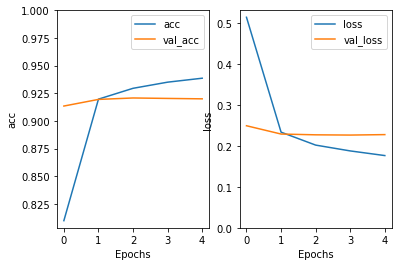

In [16]:
plt.subplot(1, 2, 1)
plot_graphs(history, 'acc')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [17]:
student = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(n_most_common_words, emb_dim//2, input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.7),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(4, activation='softmax'),
])

In [18]:
student.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 64)           512000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 130, 64)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 537,092
Trainable params: 537,092
Non-trainable params: 0
_________________________________________________________________


In [19]:
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)

            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        x, y = data
        y_prediction = self.student(x, training=False)

        student_loss = self.student_loss_fn(y, y_prediction)
        self.compiled_metrics.update_state(y, y_prediction)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [20]:
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer= tf.keras.optimizers.Adam(),
    metrics=['acc'],
    student_loss_fn= tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn= tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

In [21]:
history = distiller.fit(X_train, y_train, epochs=3, batch_size=256)

Epoch 1/3
528/528 [==============================] - 24s 35ms/step - acc: 0.6234 - student_loss: 0.5618 - distillation_loss: 2.6470e-04
Epoch 2/3
528/528 [==============================] - 18s 34ms/step - acc: 0.9145 - student_loss: 0.2493 - distillation_loss: 5.3230e-05
Epoch 3/3
528/528 [==============================] - 18s 35ms/step - acc: 0.9271 - student_loss: 0.2192 - distillation_loss: 3.9831e-05


In [22]:
txt = ["Knowledge distillation using student and teacher LSTM neural networks"]
seq = tokenizer.texts_to_sequences(txt)
padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_len)

pred = student.predict(padded)

labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

[[0.01696302 0.0370741  0.9026892  0.04327368]] science/tech
